# ResNet1D Model for ECG Classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
output_dir = "/content/drive/Shareddrives/Labs CompBioMed/results"##
os.makedirs(output_dir, exist_ok=True)

In [ ]:
import zipfile

zip_path = "/content/drive/Shareddrives/Labs CompBioMed/data.zip"

# Local directory to extract into
extract_path = "/content/data"
os.makedirs(extract_path, exist_ok=True)

# Unzip safely
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed!")

Extraction completed!


In [ ]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 119.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## 1. Label Preparation for Model Training

In [ ]:
import pandas as pd
import numpy as np
import glob
from sklearn.preprocessing import MultiLabelBinarizer
from ast import literal_eval
import wfdb

# Paths
base_dir = "/content/data/data"
csv_path = os.path.join(base_dir, "ptbxl_database.csv")
record_dir = os.path.join(base_dir, "records100")
scp_path = os.path.join(base_dir, "scp_statements.csv")

# Load metadata
variables = pd.read_csv(csv_path, index_col=0)

# Get all .dat files
files = glob.glob(os.path.join(record_dir, "**", "*.dat"), recursive=True)
ecg_ids = [int(os.path.basename(f).split("_")[0]) for f in files]
variables = variables.loc[variables.index.isin(ecg_ids)]

# Reorder to match ECG files
ordered_indices = [i for i in ecg_ids if i in variables.index]
variables = variables.loc[ordered_indices]

# Decode scp_codes
variables["scp_codes"] = variables["scp_codes"].apply(literal_eval)

# Load diagnostic map
scp_df = pd.read_csv(scp_path, index_col=0)
scp_map = scp_df[scp_df["diagnostic_class"].notnull()]["diagnostic_class"].to_dict()

# Map to superclasses
def map_to_superclass(scp_codes):
    return list({scp_map[code] for code in scp_codes if code in scp_map})

variables["diagnostic_superclass"] = variables["scp_codes"].apply(map_to_superclass)
target_labels = {"NORM", "MI", "STTC"}
variables = variables[variables["diagnostic_superclass"].apply(lambda x: bool(set(x) & target_labels))]

# Split into train and test
test_fold = 10
train_df = variables[variables["strat_fold"] != test_fold]
test_df = variables[variables["strat_fold"] == test_fold]

## 2. Signal Loading and Preprocessing

In [ ]:
# Load raw data
def load_raw_data(df, base_path):
    signals = []
    for path in df["filename_lr"]:
        signal, _ = wfdb.rdsamp(os.path.join(base_path, path))
        signals.append(signal)
    return np.array(signals)

X_train = load_raw_data(train_df, base_dir)
X_test = load_raw_data(test_df, base_dir)

# Normalize data
def normalize(ecg):
    return (ecg - np.mean(ecg, axis=0)) / (np.std(ecg, axis=0) + 1e-8)

X_train = np.array([normalize(sig) for sig in X_train])
X_test = np.array([normalize(sig) for sig in X_test])

# Binarize labels
mlb = MultiLabelBinarizer(classes=["NORM", "MI", "STTC"])
mlb.fit(variables["diagnostic_superclass"])  # fit on full data

y_train = mlb.transform(train_df["diagnostic_superclass"])
y_test = mlb.transform(test_df["diagnostic_superclass"])

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['CD', 'HYP'] will be ignored
  warnings.warn(


## 3. ResNet1D Architecture

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Helper: 1D convolution with same padding
def conv(in_planes, out_planes, kernel_size=3, stride=1):
    return nn.Conv1d(in_planes, out_planes, kernel_size=kernel_size, stride=stride,
                     padding=(kernel_size - 1) // 2, bias=False)

# Basic ResNet block for 1D
class BasicBlock1D(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1, downsample=None, kernel_size=3):
        super().__init__()
        self.conv1 = conv(in_planes, planes, kernel_size, stride)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv(planes, planes, kernel_size)
        self.bn2 = nn.BatchNorm1d(planes)
        self.downsample = downsample

    def forward(self, x):
        identity = x if self.downsample is None else self.downsample(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.relu(out)

class ResNet1D(nn.Module):
    def __init__(self, block, layers, in_channels=12, num_classes=3, base_filters=64):
        super().__init__()
        self.in_planes = base_filters
        self.conv1 = nn.Conv1d(in_channels, base_filters, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(base_filters)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, base_filters, layers[0])
        self.layer2 = self._make_layer(block, base_filters * 2, layers[1], stride=2)
        self.layer3 = self._make_layer(block, base_filters * 4, layers[2], stride=2)
        self.layer4 = self._make_layer(block, base_filters * 8, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(base_filters * 8 * block.expansion, num_classes)

        # Adding dropout layer
        self.dropout = nn.Dropout(0.5)  # Apply dropout with 50% probability

    def _make_layer(self, block, planes, num_blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.in_planes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(planes * block.expansion),
            )
        layers = [block(self.in_planes, planes, stride, downsample)]
        self.in_planes = planes * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x).squeeze(-1)
        x = self.dropout(x)  # Apply dropout before the fully connected layer
        return self.fc(x)

## 4. Model Training and Evaluation

In [ ]:
# Training setup
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Move data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 2, 1)  # (N, C, L)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 2, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64)

# Model, loss, optimizer
model = ResNet1D(BasicBlock1D, [1, 1, 1, 1], in_channels=12, num_classes=3).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 50
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

# Early stopping
best_loss = float('inf')
patience = 5
patience_counter = 0
best_epoch = 0

In [ ]:
# Training loop
for epoch in range(epochs):
    model.train()
    correct, total, train_loss = 0, 0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == y_batch).all(dim=1).sum().item()
        total += y_batch.size(0)
    train_losses.append(train_loss / total)
    train_accuracies.append(correct / total)

    # Evaluation
    model.eval()
    correct, total, test_loss = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item() * X_batch.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == y_batch).all(dim=1).sum().item()
            total += y_batch.size(0)
    test_losses.append(test_loss / total)
    test_accuracies.append(correct / total)

    # Early stopping logic
    if test_losses[-1] < best_loss:
        best_loss = test_losses[-1]
        best_epoch = epoch + 1
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
        print(f"Best model saved at epoch {epoch+1} with test loss {best_loss:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1} (Best epoch was {best_epoch})")
            break

    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Test Loss={test_losses[-1]:.4f}, Train Acc={train_accuracies[-1]:.4f}, Test Acc={test_accuracies[-1]:.4f}")

Best model saved at epoch 1 with test loss 0.3254
Epoch 1: Train Loss=0.3357, Test Loss=0.3254, Train Acc=0.7043, Test Acc=0.7340
Best model saved at epoch 2 with test loss 0.3044
Epoch 2: Train Loss=0.2988, Test Loss=0.3044, Train Acc=0.7356, Test Acc=0.7213
Epoch 3: Train Loss=0.2785, Test Loss=0.3374, Train Acc=0.7544, Test Acc=0.7499
Epoch 4: Train Loss=0.2704, Test Loss=0.3398, Train Acc=0.7648, Test Acc=0.7441
Epoch 5: Train Loss=0.2635, Test Loss=0.3123, Train Acc=0.7665, Test Acc=0.7525
Best model saved at epoch 6 with test loss 0.2821
Epoch 6: Train Loss=0.2531, Test Loss=0.2821, Train Acc=0.7790, Test Acc=0.7530
Epoch 7: Train Loss=0.2457, Test Loss=0.2937, Train Acc=0.7795, Test Acc=0.7536
Epoch 8: Train Loss=0.2386, Test Loss=0.2849, Train Acc=0.7844, Test Acc=0.7493
Epoch 9: Train Loss=0.2327, Test Loss=0.2871, Train Acc=0.7952, Test Acc=0.7710
Epoch 10: Train Loss=0.2234, Test Loss=0.2914, Train Acc=0.8010, Test Acc=0.7488
Early stopping triggered at epoch 11 (Best epoch 

In [ ]:
# Load best model
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# Re-evaluate on test set
correct, total, test_loss = 0, 0, 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == y_batch).all(dim=1).sum().item()
        total += y_batch.size(0)

final_loss = test_loss / total
final_acc = correct / total
print(f"Best model test loss: {final_loss:.4f}")
print(f"Best model test subset accuracy: {final_acc:.4f}")

Best model test loss: 0.2821
Best model test subset accuracy: 0.7530


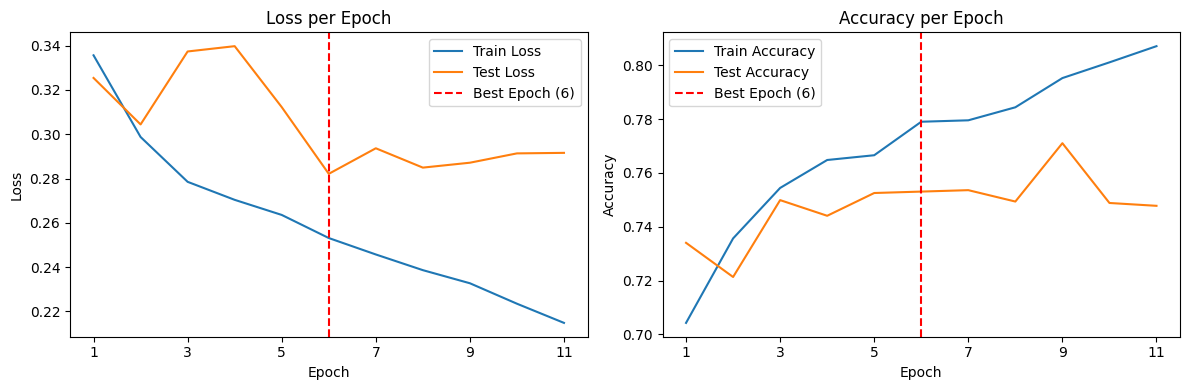

In [ ]:
import matplotlib.pyplot as plt

# Epochs range starting at 1
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.axvline(best_epoch, color='r', linestyle='--', label=f'Best Epoch ({best_epoch})')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, len(train_losses) + 1, 2))
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
plt.axvline(best_epoch, color='r', linestyle='--', label=f'Best Epoch ({best_epoch})')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(train_accuracies) + 1, 2))
plt.legend()
plt.tight_layout()
resnet_plot_path = os.path.join(output_dir, "resnet_loss_acc_curves.png")
plt.savefig(resnet_plot_path)
plt.show()

In [ ]:
from sklearn.metrics import classification_report, hamming_loss

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(y_batch.numpy())

# Concatenate all batches
all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

# Get label names
label_names = mlb.classes_

print(classification_report(all_labels, all_preds, target_names=label_names, digits=4))
print(f"Hamming Loss: {hamming_loss(all_labels, all_preds):.4f}")

              precision    recall  f1-score   support

        NORM     0.8655    0.9086    0.8865       963
          MI     0.8593    0.6327    0.7288       550
        STTC     0.7706    0.8061    0.7880       521

   micro avg     0.8378    0.8078    0.8225      2034
   macro avg     0.8318    0.7825    0.8011      2034
weighted avg     0.8395    0.8078    0.8186      2034
 samples avg     0.8191    0.8186    0.8116      2034

Hamming Loss: 0.1250


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
